In [1]:
import os
import jax

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"

import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.subplots as sp

import cbvf_reachability as cbvf

from tqdm import tqdm
from dyn_sys.DoubleIntegrator import DoubleIntegrator
from controllers.CBVF_QP import CBVFQPController
from controllers.CBVFInterpolator import CBVFInterpolator
from utils.animator import create_trajectory_animation



In [2]:
dynamics = DoubleIntegrator(control_mode='max',
                            control_space=cbvf.sets.Box(jnp.array([-0.5]), jnp.array([0.5])),
                            disturbance_mode=cbvf.sets.Box(jnp.array([0.0]), jnp.array([0.0])),)

# limits of the grid in degrees
x1_lim = 7
x2_lim = 7


grid = cbvf.Grid.from_lattice_parameters_and_boundary_conditions(cbvf.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (200, 200))
values_vi = -jnp.linalg.norm(grid.states[..., :2], axis=-1) + 6
# values_vi = jnp.zeros(grid.shape) + 1
# values_vi = jnp.where(-jnp.linalg.norm(grid.states[..., :2], axis=-1) + 6 >= 0, values_vi*10, values_vi*0)

initial_values = -jnp.linalg.norm(grid.states[..., :2], axis=-1) + 6


# initial_values = jnp.zeros_like(values_vi) + 100

times = np.linspace(0, -5, 21)

gamma = 0.0

In [3]:
jax.clear_caches()
solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
                                                  hamiltonian_postprocessor=cbvf.solver.identity,
                                                  gamma=gamma)
cbvf_values = cbvf.solve_cbvf(solver_settings=solver_settings,
                              dynamics=dynamics,
                              grid=grid,
                              times=times,
                              initial_values=values_vi,
                              target_values=initial_values, )
# solver_settings = cbvf.SolverSettings.with_accuracy(
#     "very_high",
#     hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube,
# )
# target_values = cbvf.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  5.0000/5.0 [00:09<00:00,  1.94s/sim_s]


In [ ]:
for i, time in enumerate(times):
    if i % 50 != 0:
        continue
    plt.jet()
    plt.figure(figsize=(13, 13))
    plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], cbvf_values[i, :, :].T)
    plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                cbvf_values[i, :, :].T,
                levels=0,
                colors="black",
                linewidths=3)
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                values_vi.T,
                levels=0,
                colors="white",
                linewidths=3,
                linestyles='--')
    plt.axis('equal')
    plt.title(f"Results for time {time} s")
    plt.show()



In [ ]:
f = go.Figure(data=go.Surface(z=cbvf_values[-1, :, :].T,
                              x=grid.coordinate_vectors[0],
                              y=grid.coordinate_vectors[1],
                              colorscale="Jet",
                              contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title=f"CBVF Double Integrator with gamma {gamma}",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value",
                             xaxis=dict(range=[-x1_lim, x1_lim]),
                             yaxis=dict(range=[-x2_lim, x2_lim]),
                             zaxis=dict(range=[-0, 6])),
                  width=800,
                  height=800,
                  scene_aspectmode='cube')
f.show()

In [4]:
# Get device references
cpu = jax.devices('cpu')[0]

# Move data to CPU and switch computation
target_values_cpu = jax.device_put(cbvf_values, cpu)
grid_cpu = jax.device_put(grid, cpu)
times_cpu = jax.device_put(times, cpu)

# Check both gradient components at safe region entry points
gradient_x1 = np.zeros(grid_cpu.shape)
gradient_x2 = np.zeros(grid_cpu.shape)
entry_times_grid = np.zeros(grid_cpu.shape)
entry_values_grid = np.zeros(grid_cpu.shape)

with jax.default_device(cpu):

    interpolator = CBVFInterpolator(grid=grid_cpu,
                                    cbvf_values=target_values_cpu,  # Use CPU version
                                    times=times_cpu, gamma=gamma)

    states_flat = grid_cpu.states.reshape(-1, 2)

    # Compute gradients at safe region entry points
    # entry_times, entry_values, spatial_grads, time_grads = interpolator.compute_safe_entry_gradients_efficient(states_flat)
    spatial_grads = interpolator.interpolate_spatial_gradient_vectorized(states_flat, times_cpu[-2])

    # Reshape results back to grid shape
    gradient_x1 = spatial_grads[:, 0].reshape(grid.shape)
    gradient_x2 = spatial_grads[:, 1].reshape(grid.shape)
    # entry_times_grid = entry_times.reshape(grid.shape)
    # entry_values_grid = entry_values.reshape(grid.shape)


In [5]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('∂V/∂x1 (zero along x1=0)', '∂V/∂x2 (zero along x2=0)'),
    specs=[[{'type': 'surface'}, {'type': 'surface'}]]
)

# Add ∂V/∂x1
fig.add_trace(
    go.Surface(
        z=gradient_x1,
        x=grid.coordinate_vectors[0],
        y=grid.coordinate_vectors[1],
        colorscale="RdBu",
        name="∂V/∂x1",
        contours={"z": {"show": True, "start": 0.0, "end": 0.0, "size": 1}}
    ),
    row=1, col=1
)

# Add ∂V/∂x2
fig.add_trace(
    go.Surface(
        z=gradient_x2,
        x=grid.coordinate_vectors[0],
        y=grid.coordinate_vectors[1],
        colorscale="RdBu",
        name="∂V/∂x2",
        contours={"z": {"show": True, "start": 0.0, "end": 0.0, "size": 1}}
    ),
    row=1, col=2
)

fig.update_layout(
    title="Cone Gradient Components (Zero Contours Show Symmetry Lines)",
    scene=dict(xaxis_title="x1", yaxis_title="x2", zaxis_title="∂V/∂x1"),
    scene2=dict(xaxis_title="x1", yaxis_title="x2", zaxis_title="∂V/∂x2"),
    height=600
)
fig.show()

In [ ]:
# plot the time of entry of every point into the safe set
plt.jet()
plt.figure(figsize=(13, 13))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], entry_times_grid.T)
plt.colorbar()
plt.show()

In [ ]:
x_init = np.array([3.0, -0.0])
target = np.array([-4.0, -1.0])


# coefficients of a PD controller
k_p = 0.2
k_d = 0.5

interpolator = CBVFInterpolator(grid=grid,
                                cbvf_values=cbvf_values,  # Use CPU version
                                times=times, gamma=gamma)

safe_controller = CBVFQPController(value_fn=interpolator,
                                   gamma=0.0,
                                   verbose=False,)

sim_time = np.linspace(0, 5.0, 1000)
dt = sim_time[1] - sim_time[0]

trajectory = np.zeros((len(sim_time), 2))
trajectory_pd = np.zeros((len(sim_time), 2))
control_his = np.zeros(len(sim_time))
control_ref = np.zeros(len(sim_time))
constrain_his = np.zeros(len(sim_time))
cbvf_vals = np.zeros(len(sim_time))
cbvf_grad_x = np.zeros((len(sim_time), 2))
cbvf_grad_t = np.zeros(len(sim_time))
a_term = np.zeros(len(sim_time))
constrain_rest_hist = np.zeros(len(sim_time))

state = x_init.copy()
state_pd = x_init.copy()

for i, time in enumerate(tqdm(sim_time, desc="Simulation", unit="sim_s", unit_scale=dt)):
    # grad_time = interpolator.compute_safe_entry_gradients_efficient(jnp.array(state).reshape(1, -1))[0]
    cbvf_vals[i], cbvf_grad_x[i], cbvf_grad_t[i] = safe_controller.cbvf.get_value_and_gradient(state, times[-1])
    # u = k_p * (target[0] - state[0]) + k_d * (target[1] - state[1])
    u = -1
    u_pd = k_p * (target[0] - state_pd[0]) + k_d * (target[1] - state_pd[1])
    control_ref[i] = u
    u_prev = 0.0 if i == 0 else control_his[i - 1]
    u_safe, constrain_his[i], a_term[i] = safe_controller.compute_safe_control(state=state, time=time,
                                                  u_ref=u, dynamics=dynamics,
                                                  u_prev=u_prev,
                                                  u_max_mag = 0.5,
                                                  gradient_time=[times[-2]],)
    state_dot = dynamics.open_loop_dynamics(state=state, time=time) + dynamics.control_jacobian(state, time) @ np.array([u_safe])
    state_dot_pd = dynamics.open_loop_dynamics(state=state_pd, time=time) + dynamics.control_jacobian(state_pd, time) @ np.array([u_pd])
    state = state + state_dot * dt
    state_pd = state_pd + state_dot_pd * dt

    trajectory[i, :] = state
    trajectory_pd[i, :] = state_pd
    control_his[i] = u_safe

constrain_rest_hist = constrain_his - a_term



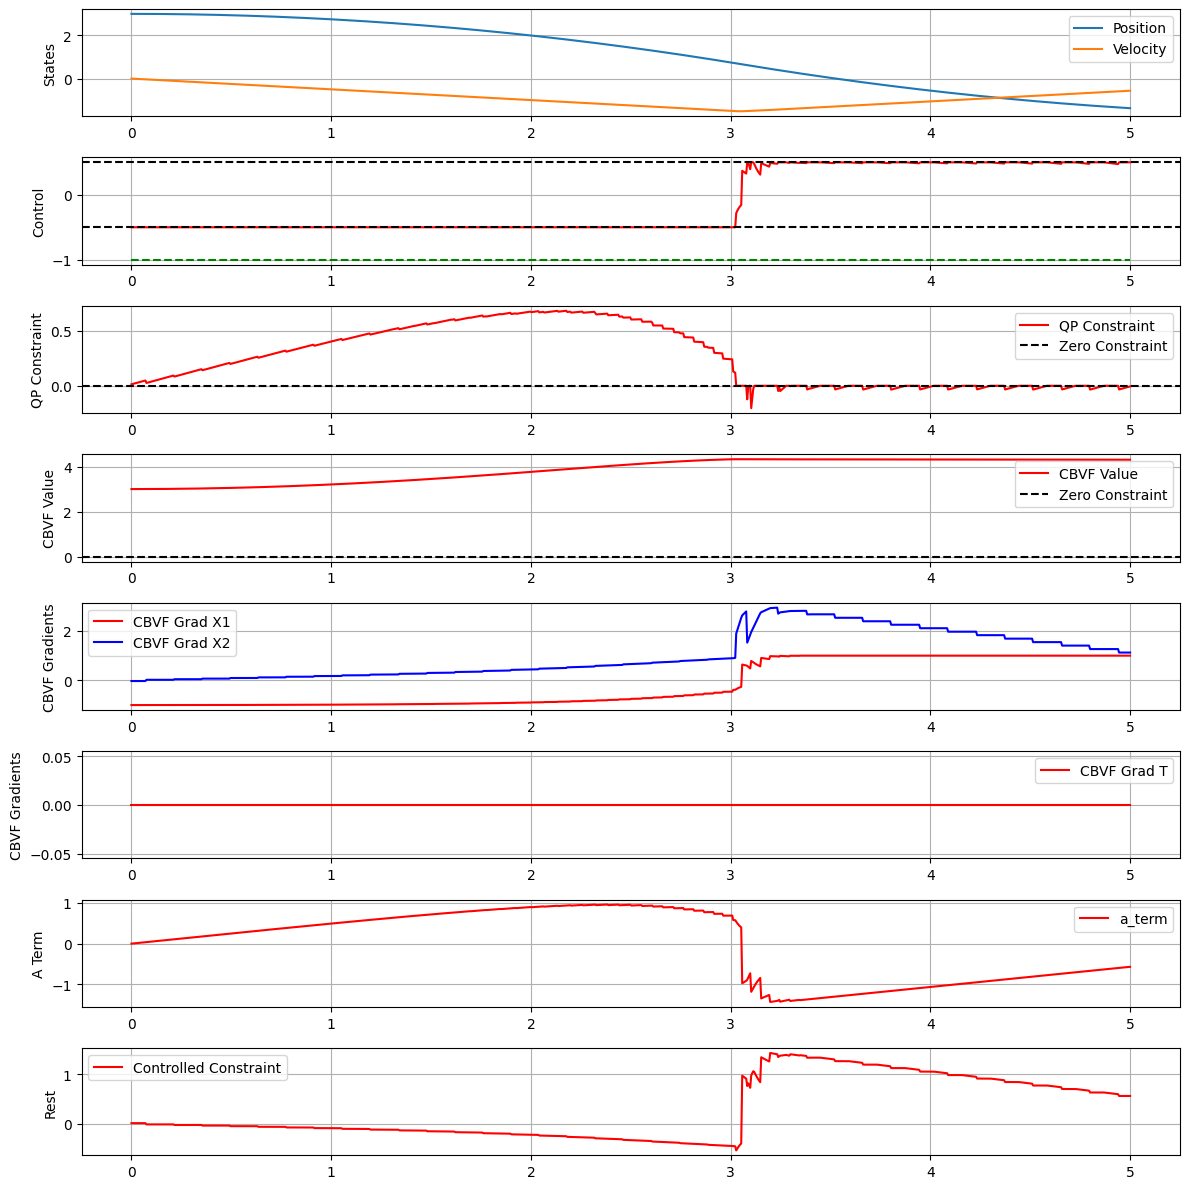

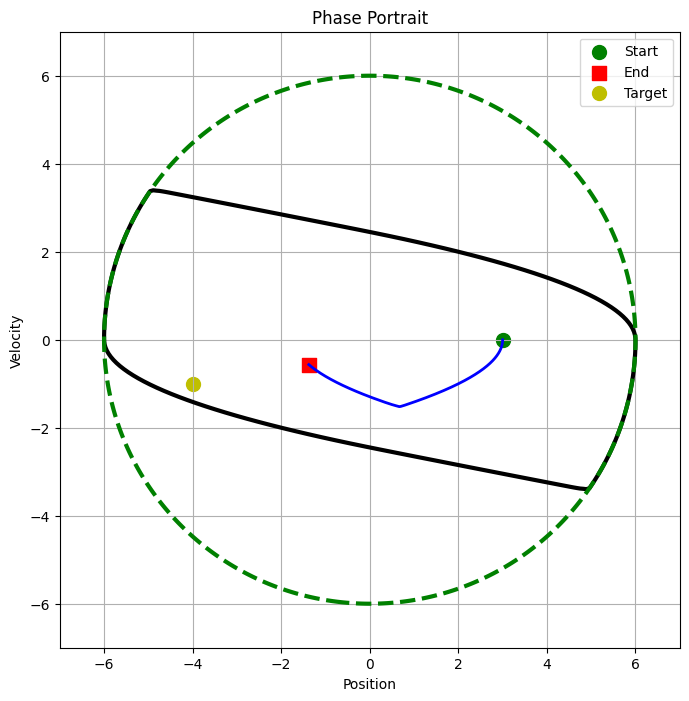

In [8]:
# Plot results
fig, axes = plt.subplots(8, 1, figsize=(12, 12))

# State trajectory
axes[0].plot(sim_time, trajectory[:, 0], label='Position')
axes[0].plot(sim_time, trajectory[:, 1], label='Velocity')
axes[0].set_ylabel('States')
axes[0].legend()
axes[0].grid(True)

# Control input
axes[1].plot(sim_time, control_his, 'r-', label='Control Input')
axes[1].plot(sim_time, control_ref, 'g--', label='Reference Control')
axes[1].axhline(dynamics.control_space.lo, color='black', linestyle='--', label='Control Limit')
axes[1].axhline(dynamics.control_space.hi, color='black', linestyle='--')
axes[1].set_ylabel('Control')
# axes[1].legend()
axes[1].grid(True)

# QP Constraints
axes[2].plot(sim_time, constrain_his, 'r-', label='QP Constraint')
axes[2].axhline(0, color='black', linestyle='--', label='Zero Constraint')
axes[2].set_ylabel('QP Constraint')
axes[2].legend()
axes[2].grid(True)

# CBVF Values
axes[3].plot(sim_time, cbvf_vals, 'r-', label='CBVF Value')
axes[3].axhline(0, color='black', linestyle='--', label='Zero Constraint')
axes[3].set_ylabel('CBVF Value')
axes[3].legend()
axes[3].grid(True)

# CBVF Gradients X
axes[4].plot(sim_time, cbvf_grad_x[:, 0], 'r-', label='CBVF Grad X1')
axes[4].plot(sim_time, cbvf_grad_x[:, 1], 'b-', label='CBVF Grad X2')
axes[4].set_ylabel('CBVF Gradients')
axes[4].legend()
axes[4].grid(True)

# CBVF Gradients T
axes[5].plot(sim_time, cbvf_grad_t, 'r-', label='CBVF Grad T')
axes[5].set_ylabel('CBVF Gradients')
axes[5].legend()
axes[5].grid(True)

# A Term in Constraint
axes[6].plot(sim_time, a_term, 'r-', label='a_term')
axes[6].set_ylabel('A Term')
axes[6].legend()
axes[6].grid(True)

# Controlled Constraint
axes[7].plot(sim_time, constrain_rest_hist, 'r-', label='Controlled Constraint')
axes[7].set_ylabel('Rest')
axes[7].legend()
axes[7].grid(True)

plt.tight_layout()
plt.show()

# Phase portrait
plt.figure(figsize=(8, 8))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2)
plt.scatter(x_init[0], x_init[1], color='g', s=100, marker='o', label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='r', s=100, marker='s', label='End')
plt.scatter(target[0], target[1], color='y', s=100, marker='o', label='Target')
# plt.plot(trajectory_pd[:, 0], trajectory_pd[:, 1], 'k--', linewidth=2, label='PD Trajectory')


plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Portrait')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.xlim(-x1_lim, x1_lim)
plt.ylim(-x2_lim, x2_lim)
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            cbvf_values[-1, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                values_vi.T,
                levels=0,
                colors="green",
                linewidths=3,
                linestyles='--')
plt.show()

In [ ]:
# 3D Trajectory Visualization on Value Function Surface
import plotly.graph_objects as go

# Use the already computed CBVF values along the trajectory
trajectory_z = cbvf_vals

# Convert JAX arrays to numpy for compatibility
value_function_surface = np.array(cbvf_values[-1, :, :].T)

# Create the figure with the value function surface
fig = go.Figure()

# Add the value function surface
fig.add_trace(go.Surface(
    z=value_function_surface,
    x=grid.coordinate_vectors[0],
    y=grid.coordinate_vectors[1],
    colorscale="Jet",
    opacity=0.8,
    name="Value Function",
    contours={
        "z": {
            "show": True,
            "start": 0.00,
            "end": 0.00,
            "size": 1
        }
    }
))

# Add trajectory as a 3D line using computed CBVF values
fig.add_trace(go.Scatter3d(
    x=trajectory[:, 0],  # position
    y=trajectory[:, 1],  # velocity
    z=trajectory_z,      # computed CBVF values along trajectory
    mode='lines+markers',
    line=dict(color='white', width=8),
    marker=dict(size=3, color='white'),
    name='Trajectory',
    hovertemplate='<b>Trajectory Point</b><br>' +
                  'Time: %{customdata[0]:.3f} s<br>' +
                  'Position: %{x:.3f}<br>' +
                  'Velocity: %{y:.3f}<br>' +
                  'CBVF Value: %{z:.3f}<br>' +
                  'Control Input: %{customdata[1]:.3f}<br>' +
                  '<extra></extra>',
    customdata=np.column_stack([sim_time, control_his])
))

# Add start point
fig.add_trace(go.Scatter3d(
    x=[x_init[0]],
    y=[x_init[1]],
    z=[cbvf_vals[0]],  # Use first CBVF value
    mode='markers',
    marker=dict(color='lime', size=15, symbol='circle'),
    name='Start'
))

# Add end point
fig.add_trace(go.Scatter3d(
    x=[trajectory[-1, 0]],
    y=[trajectory[-1, 1]],
    z=[cbvf_vals[-1]],  # Use last CBVF value
    mode='markers',
    marker=dict(color='red', size=15, symbol='square'),
    name='End'
))

# Add target point (use interpolator for target since it's not on trajectory)
from scipy.interpolate import RegularGridInterpolator
interpolator_target = RegularGridInterpolator(
    (grid.coordinate_vectors[1], grid.coordinate_vectors[0]),
    value_function_surface,  # Already converted to numpy
    bounds_error=False,
    fill_value=0
)
target_z = interpolator_target([target[1], target[0]])
fig.add_trace(go.Scatter3d(
    x=[target[0]],
    y=[target[1]],
    z=[target_z],
    mode='markers',
    marker=dict(color='yellow', size=15, symbol='diamond'),
    name='Target'
))

# Update layout
fig.update_layout(
    title=f"3D Trajectory on CBVF Surface (γ={gamma})",
    scene=dict(
        xaxis_title="Position (x1)",
        yaxis_title="Velocity (x2)",
        zaxis_title="Value Function",
        xaxis=dict(range=[-x1_lim, x1_lim]),
        yaxis=dict(range=[-x2_lim, x2_lim]),
        zaxis=dict(range=[-6, 6]),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=1000,
    height=800,
    scene_aspectmode='cube'
)

fig.show()